In [1]:
import numpy as np
from scipy.misc import derivative
from scipy.interpolate import approximate_taylor_polynomial
from math import factorial, sin, exp, cos, log
from scipy.special import perm, comb
from collections import defaultdict
from enum import Enum
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
class FuncTypes(Enum):
    SINUSOIDAL = "Sinusoidal"
    SINE = "Sin"
    COSINE = "Cos"
    EXPONENTIAL = "Exponential"
    LOGARITHMIC = "Log"
    
    def isIn(functype):
        if (type(functype) is str):
            if (functype == FuncTypes.SINUSOIDAL.value or
                functype == FuncTypes.SINE.value or
                functype == FuncTypes.COSINE.value or
                functype == FuncTypes.EXPONENTIAL.value or
                functype == FuncTypes.LOGARITHMIC.value):
                return 1
            else:
                return 0
        else:
            if (functype == FuncTypes.SINUSOIDAL or
                functype == FuncTypes.SINE or
                functype == FuncTypes.COSINE or
                functype == FuncTypes.EXPONENTIAL or
                functype == FuncTypes.LOGARITHMIC):
                return 1
            else:
                return 0

In [3]:
class GateTypes(Enum):
    NAND = "Nand"
    AND = "And"
    BNAND = "Bipolar Nand"
    BAND = "Bipolar And"
    MUX = "MUX"
    
    def isIn(functype):
        if (type(functype) is str):
            if (functype == GateTypes.NAND.value or
                functype == GateTypes.AND.value or
                functype == GateTypes.BNAND.value or
                functype == GateTypes.BAND.value or
                functype == GateTypes.MUX.value):
                return 1
            else:
                return 0
        else:        
            if (functype == GateTypes.NAND or
                functype == GateTypes.AND or
                functype == GateTypes.BNAND or
                functype == GateTypes.BAND or
                functype == GateTypes.MUX):
                return 1
            else:
                return 0

In [4]:
class NotGateTypes(Enum):
    INPUT = "Input"
    OUTPUT = "Output"
    CONSTANT = "Const"
    INTERMEDIATE = "Intermediate"
    
    def isIn(functype):
        if (type(functype) is str):
            if (functype == NotGateTypes.INPUT.value or
                functype == NotGateTypes.OUTPUT.value or
                functype == NotGateTypes.CONSTANT.value or
                functype == NotGateTypes.INTERMEDIATE.value):
                return 1
            else:
                return 0
        else:
            if (functype == NotGateTypes.INPUT or
                functype == NotGateTypes.OUTPUT or
                functype == NotGateTypes.CONSTANT or
                functype == NotGateTypes.INTERMEDIATE):
                return 1
            else:
                return 0

In [5]:
def make_taylor_coeffs(func):
    coeffs = {}
    for n in range(func.order):
        order = (n+1) if n%2 == 0 else (n+2)
        if (func.isSinusoidal()):
            coeffs[n] = derivative(func.function, func.point, n=n, order=order, dx=1e-2) / factorial(n)
        else:
            coeffs[n] = derivative(func.function, func.point, n=n, order=order, dx=1e-3) / factorial(n)
    return coeffs

In [6]:
def expand_binomial(point, n):
    coeffs = dict()
    for k in range(n+1):
        coeff = ((-1)**k) * comb(n, k) * (point ** k)
        coeffs[n-k] = coeff
    return coeffs

In [7]:
def make_polynomial(func):
    if func.point == 0:
        return func.taylor_coeffs
    else:
        new_taylor_coeffs = []
        final_dict = defaultdict(list)
        for power, coef in func.taylor_coeffs.items():
            temp_dict = expand_binomial(point, power)
            temp_dict.update((x, y*coef) for x, y in temp_dict.items())
            new_taylor_coeffs.append(temp_dict)
        for d in new_taylor_coeffs:
            for key, value in d.items():
                final_dict[key].append(value)
        final_dict.update((x, sum(y)) for x, y in final_dict.items())
        return dict(final_dict)

In [8]:
def ignore_small_coeffs(coeffs, ignore_th=1e-4):
    coeffs_new = {}
    for index in coeffs:
        if abs(coeffs[index]) > ignore_th:
            coeffs_new[index] = coeffs[index]
    return coeffs_new

In [9]:
def make_horner(func):
    func.horner_coeffs = ignore_small_coeffs(func.poli_coeffs)
    horner_coeffs = {}

    for counter, index in enumerate(func.horner_coeffs):
        if counter == 0:
            horner_coeffs[index] = func.horner_coeffs[index]
        else:
            horner_coeffs[index] = -func.horner_coeffs[index]/func.horner_coeffs[prev_index]
        prev_index = index
    return horner_coeffs

In [10]:
def AddBaseGate(graph, gateIndex, gateType, val1Type, value1, val2Type, value2):
    assert gateType in [GateTypes.NAND.value, 
                         GateTypes.BNAND.value, 
                         GateTypes.AND.value, 
                         GateTypes.BAND.value, 
                         GateTypes.MUX.value]
    
    #add check to ignore unnecessary AND gate
    #if ((gateType == GateTypes.AND.value and (value1 <= 1+1e-4 and value1 >= 1-1e-4)
    #    or gateType == GateTypes.AND.value and (value2 <= 1+1e-4 and value2 >= 1-1e-4)) and gateIndex != 1):
    #    gateIndex = gateIndex - 1
    #    return graph
    
    if (type(value1) is not str):
        graph.add_edge((val1Type, str(round(value1, 5))),
                       (gateType, "G"+str(gateIndex)))
    else:
        graph.add_edge((val1Type, value1),
                       (gateType, "G"+str(gateIndex)))
        
    if (type(value2) is not str):
        graph.add_edge((val2Type, str(round(value2, 5))),
                       (gateType, "G"+str(gateIndex)))
    else:
        graph.add_edge((val2Type, value2),
                       (gateType, "G"+str(gateIndex)))
    
    return graph

In [59]:
def AddGateFromGate(graph, prevGateType, prevGateIndex, newGateIndex, gateType, valType, value):
    assert gateType in [GateTypes.NAND.value, 
                         GateTypes.BNAND.value, 
                         GateTypes.AND.value, 
                         GateTypes.BAND.value, 
                         GateTypes.MUX.value]
    
    #add check to ignore unnecessary AND gate
    #if (valType == NotGateTypes.CONSTANT.value):
    #    if (gateType == GateTypes.AND.value and (float(value) <= 1.0001 and float(value) >= 0.9998)):
    #        newGateIndex = newGateIndex - 1
    #        return graph
    #else:
    graph.add_edge((prevGateType, "G"+str(prevGateIndex)),
                   (gateType, "G"+str(newGateIndex)))
    if (type(value) is not str):
        graph.add_edge((valType, str(round(value, 5))),
                       (gateType, "G"+str(newGateIndex)))
    else:
        graph.add_edge((valType, value),
                       (gateType, "G"+str(newGateIndex)))

    return graph

In [74]:
def horner_to_circuit(func):    
    graph = nx.DiGraph()
    gateIndex = 1
    coeffs = func.horner_coeffs
    
    transCoeffs = reversed(coeffs)

    # Ways to create a gate:
    #           AddGate(graph, gateIndex, gateType, val1Type, value1, val2Type, value2)
    #           AddGateFromGate(graph, prevGateType, prevGateIndex, newGateIndex, gateType, valType, value)
    #
    
    if (func.isSinusoidal()): #only uses x^2
        numX = 1
        for index in transCoeffs:
            if (list(coeffs.keys())[(len(coeffs)-1)] == index): # First grouping (innermost 1-jx^2, where j is coeff)
                # AND x with itself (x^2)
                AddBaseGate(graph, gateIndex, GateTypes.AND.value,  #graph, GIndex, GateType
                        NotGateTypes.INPUT.value, "X"+str(numX),    #Value1 Type, Value1
                        NotGateTypes.INPUT.value, "X"+str(numX+1))  #Value2 Type, Value2
                numX = numX + 2
                gateIndex = gateIndex + 1
                
                # NAND prev result with next coeff last coefficient
                AddGateFromGate(graph, GateTypes.AND.value, gateIndex - 1,  #graph, prevGateType, prevGateIndex
                                gateIndex, GateTypes.NAND.value,            #newGateIndex, gateType
                                NotGateTypes.CONSTANT.value, coeffs[index]) #valType, value
                gateIndex = gateIndex + 1
                
            else:
                if (index != 1 and index != 0): #In between groupings (next few 1-jx^2, where j is coeff)
                    # AND x with itself (x^2)
                    AddBaseGate(graph, gateIndex, GateTypes.AND.value,  #graph, GIndex, GateType
                            NotGateTypes.INPUT.value, "X"+str(numX),    #Value1 Type, Value1
                            NotGateTypes.INPUT.value, "X"+str(numX+1))  #Value2 Type, Value2
                    numX = numX + 2
                    gateIndex = gateIndex + 1
                    
                    # AND prev result (gIndex - 2) with new x^2 value (gIndex - 1)
                    AddGateFromGate(graph, GateTypes.AND.value, gateIndex - 1,    #graph, prevGateType, prevGateIndex
                                    gateIndex, GateTypes.AND.value,               #newGateIndex, gateType
                                    GateTypes.NAND.value, "G"+str(gateIndex - 2)) #valType, value
                    gateIndex = gateIndex+1
                    
                    # NAND prev result with next coeff
                    AddGateFromGate(graph, GateTypes.AND.value, gateIndex - 1,  #graph, prevGateType, prevGateIndex
                                    gateIndex, GateTypes.NAND.value,            #newGateIndex, gateType
                                    NotGateTypes.CONSTANT.value, coeffs[index]) #valType, value
                    gateIndex = gateIndex + 1
                    
                else: #last grouping where case 1: jx(1-kx^2(...)) is last group (i == 1), or case 2: 1-jx^2(...) is last group (i == 0)
                    if (index == 1): # case 1, last term, sin(x)
                        # AND prev result with X
                        AddGateFromGate(graph, GateTypes.NAND.value, gateIndex - 1, #graph, prevGateType, prevGateIndex
                                        gateIndex, GateTypes.AND.value,             #newGateIndex, gateType
                                        NotGateTypes.INPUT.value, "X"+str(numX))    #valType, value
                        numX = numX + 1
                        gateIndex = gateIndex + 1
                        
                        # AND prev result with first coeff
                        AddGateFromGate(graph, GateTypes.AND.value, gateIndex - 1,  #graph, prevGateType, prevGateIndex
                                        gateIndex, GateTypes.AND.value,             #newGateIndex, gateType
                                        NotGateTypes.CONSTANT.value, coeffs[index]) #valType, value
                        gateIndex = gateIndex + 1
                        
                    else: # case 2, index == 0, last term, cos(x)
                        # AND prev result with first coeff
                        AddGateFromGate(graph, GateTypes.NAND.value, gateIndex - 1, #graph, prevGateType, prevGateIndex
                                        gateIndex, GateTypes.AND.value,             #newGateIndex, gateType
                                        NotGateTypes.CONSTANT.value, coeffs[index]) #valType, value
                        gateIndex = gateIndex + 1
        
    else: #only uses x^1
        numX = 1
        for index in transCoeffs:
            if (list(coeffs.keys())[(len(coeffs)-1)] == index): # First grouping (innermost 1-jx, where j is coeff)
                # NAND X and last coeff
                AddBaseGate(graph, gateIndex, GateTypes.NAND.value, #graph, GIndex, GateType
                        NotGateTypes.INPUT.value, "X"+str(numX),    #Value1 Type, Value1
                        NotGateTypes.CONSTANT.value, coeffs[index]) #Value2 Type, Value2
                numX = numX + 1
                gateIndex = gateIndex + 1
                
            else:
                if (index != 1 and index != 0): # In between groupings (next few 1-jx, where j is coeff)
                    # AND prev result with next coeff
                    AddGateFromGate(graph, GateTypes.NAND.value, gateIndex - 1, #graph, prevGateType, prevGateIndex
                                    gateIndex, GateTypes.AND.value,             #newGateIndex, gateType
                                    NotGateTypes.CONSTANT.value, coeffs[index]) #valType, value
                    gateIndex = gateIndex + 1
                    
                    # NAND prev result with X
                    AddGateFromGate(graph, GateTypes.AND.value, gateIndex - 1, #graph, prevGateType, prevGateIndex
                                    gateIndex, GateTypes.NAND.value,           #newGateIndex, gateType
                                    NotGateTypes.INPUT.value, "X"+str(numX))   #valType, value
                    numX = numX + 1
                    gateIndex = gateIndex + 1
                    
                else: # Last grouping, where case 1: jx(...) is last group (i == 1), or case 2: j(1-kx(...)) is last group (i == 0)
                    if (index == 1):
                        # AND prev result with next coeff
                        AddGateFromGate(graph, GateTypes.NAND.value, gateIndex - 1, #graph, prevGateType, prevGateIndex
                                        gateIndex, GateTypes.AND.value,             #newGateIndex, gateType
                                        NotGateTypes.CONSTANT.value, coeffs[index]) #valType, value
                        gateIndex = gateIndex + 1
                            
                        # AND prev output with X
                        AddGateFromGate(graph, GateTypes.AND.value, gateIndex - 1, #graph, prevGateType, prevGateIndex
                                        gateIndex, GateTypes.AND.value,            #newGateIndex, gateType
                                        NotGateTypes.INPUT.value, "X"+str(numX))   #valType, value
                        numX = numX + 1
                        gateIndex = gateIndex + 1
                            
                        if (0 not in list(coeffs.keys())): #case 1
                            break    
                            
                    else: #case 2
                        # AND prev result with next coeff
                        temp_gate_nodes = []
    
                        for node in graph.nodes():
                            for gate in GateTypes:
                                if (node[0] == gate.value):
                                    temp_gate_nodes.append(node)
                                
                        if (temp_gate_nodes[(len(temp_gate_nodes) - 1)][0] == GateTypes.AND.value):
                            AddGateFromGate(graph, GateTypes.AND.value, gateIndex - 1, #graph, prevGateType, prevGateIndex
                                            gateIndex, GateTypes.AND.value,             #newGateIndex, gateType
                                            NotGateTypes.CONSTANT.value, coeffs[index]) #valType, value
                            gateIndex = gateIndex + 1

                        elif (temp_gate_nodes[(len(temp_gate_nodes) - 1)][0] == GateTypes.NAND.value):
                            AddGateFromGate(graph, GateTypes.NAND.value, gateIndex - 1, #graph, prevGateType, prevGateIndex
                                            gateIndex, GateTypes.AND.value,             #newGateIndex, gateType
                                            NotGateTypes.CONSTANT.value, coeffs[index]) #valType, value
                            gateIndex = gateIndex + 1
    
    gate_nodes = []
    
    for node in graph.nodes():
        if (GateTypes.isIn(node[0])):
            gate_nodes.append(node)

    if (gate_nodes[(len(gate_nodes) - 1)][0] == GateTypes.AND.value):
        graph.add_edge((GateTypes.AND.value, "G"+str(gateIndex - 1)),
                       (NotGateTypes.OUTPUT.value, "f(x)"))
        
    elif (gate_nodes[(len(gate_nodes) - 1)][0] == GateTypes.NAND.value):
        graph.add_edge((GateTypes.NAND.value, "G"+str(gateIndex - 1)),
                       (NotGateTypes.OUTPUT.value, "f(x)"))
    
    for node in gate_nodes:
        print(node[0] + " - " + node[1])
        print(list(graph.predecessors(node)))
        print("="*100) 
    
    return graph

In [124]:
def removeFrivolous(graph):
    pass
    gate_nodes = []
    
    #
    #    graph.predecessors(node) (G1)
    #    node                     (G2)
    #    graph.neighbors(node)    (G3)
    #
    
    for node in graph.nodes():
        if (GateTypes.isIn(node[0])):
            if (node[0] is GateTypes.AND.value): #is an AND Gate
                if (list(graph.predecessors(node))[0][0] is NotGateTypes.CONSTANT.value): #the first gate input is a constant
                    print(list(graph.predecessors(node)))
                    
                    if (float(list(graph.predecessors(node))[0][1]) <= 1.0001 or 
                        float(list(graph.predecessors(node))[0][1]) >= 0.9998):     # Can be removed (AND 1 and another number)
                        
                        nx.relabel_nodes() #nx.relabel_nodes(graph, mapping)
                        
                elif (list(graph.predecessors(node))[1][0] is NotGateTypes.CONSTANT.value): #the second gate input is a constant
                    print (list(graph.predecessors(node)))
                    
                    if (float(list(graph.predecessors(node))[1][1]) <= 1.0001 or 
                        float(list(graph.predecessors(node))[1][1]) >= 0.9998):     # Can be removed (AND another number and 1)
                        
                        nx.relabel_nodes() #nx.relabel_nodes(graph, mapping)
    
    #for node in gate_nodes:
    #    print(node[0] + " - " + node[1])
    #    print(list(graph.predecessors(node)))
    #    print("="*100) 
    
    return graph

In [119]:
def show_graph(graph):
    plt.figure(figsize=(10,10))
    pos = nx.spring_layout(graph)
    
    color_map = []
    temp = 0
    for node in graph.nodes():
        
        if (GateTypes.isIn(node[0])):
            color_map.append("orange")
            temp = 1
                
        if (NotGateTypes.isIn(node[0])):
            color_map.append("yellow")
            temp = 1
                
        if (temp == 0):
            color_map.append("red")
        else:
            temp = 0
        
    nx.draw_networkx_nodes(graph, pos, node_color=color_map)
    nx.draw_networkx_labels(graph, pos)
    nx.draw_networkx_edges(graph, pos, edge_color='b', arrows=True)

    plt.show()

In [120]:
def make_reactions(graph):
    for node in graph:
        if (GateTypes.isIn(node[0])):
            reaction = make_reaction(node[0], list(graph.predecessors(node)), list(graph.neighbors(node)))
            for r in reaction:
                print(r)
            print("-"*100)

In [121]:
def make_reaction(gate_type, input_substances, output_substances):
    assert gate_type in [GateTypes.NAND.value, 
                         GateTypes.BNAND.value, 
                         GateTypes.AND.value, 
                         GateTypes.BAND.value, 
                         GateTypes.MUX.value]
    
    assert len(input_substances) == 2
    assert len(output_substances) == 1
    
    print(gate_type)
    print(input_substances)
    print(output_substances)
    
    a = input_substances[0][1]
    b = input_substances[1][1]
    c = output_substances[0][1]
    
    if gate_type == GateTypes.AND.value:
        reaction_list = [
            f"{a}_0 + {b}_0 -> {c}_0",
            f"{a}_0 + {b}_1 -> {c}_0",
            f"{a}_1 + {b}_0 -> {c}_0",
            f"{a}_1 + {b}_1 -> {c}_1",
        ]
    elif gate_type == GateTypes.NAND.value:
        reaction_list = [
            f"{a}_0 + {b}_0 -> {c}_1",
            f"{a}_0 + {b}_1 -> {c}_1",
            f"{a}_1 + {b}_0 -> {c}_1",
            f"{a}_1 + {b}_1 -> {c}_0",
        ]
    else:
        print("GATE ERROR: Given Gate Type ", gate_type)
        return -1
    return reaction_list

In [122]:
class Function():
    def __init__(self, function, point, order, functype):
        self.function = function
        self.point = point
        self.order = order
        self.functype = functype
        
    def generateCoeffs(self):
        print("-"*100)
        print("Taylor Coeffs")
        print("")
        self.taylor_coeffs = make_taylor_coeffs(self)
        for index in self.taylor_coeffs:
            print(index, ": ", self.taylor_coeffs[index])
        
        print("-"*100)
        print("Polynomial Coeffs")
        print("")
        self.poli_coeffs = make_polynomial(self)
        for index in self.poli_coeffs:
            print(index, ": ", self.poli_coeffs[index])
        
        print("-"*100)
        print("Horner Expansion Coeffs")
        print("")
        self.horner_coeffs = make_horner(self)
        for index in self.horner_coeffs:
            print(index, ": ", self.horner_coeffs[index])
    
    def generateCircuit(self):
        self.circuit = horner_to_circuit(self)
        show_graph(self.circuit)
        
    def generateReactions(self):
        self.reactions = make_reactions(self.circuit)
        self.reactions
    
    def isSinusoidal(self):
        if (self.functype == FuncTypes.SINUSOIDAL):
            return 1
        elif (self.functype == FuncTypes.SINE):
            return 1
        elif (self.functype == FuncTypes.COSINE):
            return 1
        else:
            return 0
    
    def isExponential(self):
        if (self.functype == FuncTypes.EXPONENTIAL):
            return 1
        else:
            return 0
    
    def isLogarithmic(self):
        if (self.functype == FuncTypes.LOGARITHMIC):
            return 1
        else:
            return 0

# See What it is like!

## f1(x) = exp(-x)

----------------------------------------------------------------------------------------------------
Taylor Coeffs

0 :  1.0
1 :  -1.0000001666666813
2 :  0.5000000417032524
3 :  -0.16666670821230412
4 :  0.04162873749417409
5 :  -0.008326672684688672
----------------------------------------------------------------------------------------------------
Polynomial Coeffs

0 :  1.0
1 :  -1.0000001666666813
2 :  0.5000000417032524
3 :  -0.16666670821230412
4 :  0.04162873749417409
5 :  -0.008326672684688672
----------------------------------------------------------------------------------------------------
Horner Expansion Coeffs

0 :  1.0
1 :  1.0000001666666813
2 :  0.4999999583699187
3 :  0.33333338862243533
4 :  0.2497723627033324
5 :  0.20002222469163242

Nand - G1
[('Input', 'X1'), ('Const', '0.20002')]
And - G2
[('Nand', 'G1'), ('Const', '0.24977')]
Nand - G3
[('And', 'G2'), ('Input', 'X2')]
And - G4
[('Nand', 'G3'), ('Const', '0.33333')]
Nand - G5
[('And', 'G4'), ('Input', 'X3')]
An

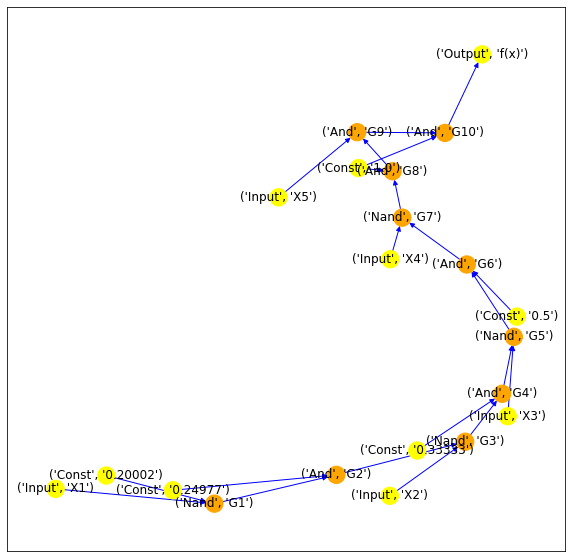


Nand
[('Input', 'X1'), ('Const', '0.20002')]
[('And', 'G2')]
X1_0 + 0.20002_0 -> G2_1
X1_0 + 0.20002_1 -> G2_1
X1_1 + 0.20002_0 -> G2_1
X1_1 + 0.20002_1 -> G2_0
----------------------------------------------------------------------------------------------------
And
[('Nand', 'G1'), ('Const', '0.24977')]
[('Nand', 'G3')]
G1_0 + 0.24977_0 -> G3_0
G1_0 + 0.24977_1 -> G3_0
G1_1 + 0.24977_0 -> G3_0
G1_1 + 0.24977_1 -> G3_1
----------------------------------------------------------------------------------------------------
Nand
[('And', 'G2'), ('Input', 'X2')]
[('And', 'G4')]
G2_0 + X2_0 -> G4_1
G2_0 + X2_1 -> G4_1
G2_1 + X2_0 -> G4_1
G2_1 + X2_1 -> G4_0
----------------------------------------------------------------------------------------------------
And
[('Nand', 'G3'), ('Const', '0.33333')]
[('Nand', 'G5')]
G3_0 + 0.33333_0 -> G5_0
G3_0 + 0.33333_1 -> G5_0
G3_1 + 0.33333_0 -> G5_0
G3_1 + 0.33333_1 -> G5_1
---------------------------------------------------------------------------------

In [125]:
#    Function(lambda function, point, order, function type)
f1 = Function(lambda x: exp(-x), 0, 6, FuncTypes.EXPONENTIAL)

f1.generateCoeffs()
print("")
f1.generateCircuit()
print("")
f1.generateReactions()
#print("")
#print("Frivolous Gates")
#removeFrivolous(f1.circuit)

## f2(x) = sin(x)

----------------------------------------------------------------------------------------------------
Taylor Coeffs

0 :  0.0
1 :  0.9999833334166665
2 :  0.0
3 :  -0.16666250004145527
4 :  7.228014483236695e-11
5 :  0.008333053286753895
6 :  -1.5419764230904951e-07
7 :  -0.00019722153804260125
----------------------------------------------------------------------------------------------------
Polynomial Coeffs

0 :  0.0
1 :  0.9999833334166665
2 :  0.0
3 :  -0.16666250004145527
4 :  7.228014483236695e-11
5 :  0.008333053286753895
6 :  -1.5419764230904951e-07
7 :  -0.00019722153804260125
----------------------------------------------------------------------------------------------------
Horner Expansion Coeffs

1 :  0.9999833334166665
3 :  0.16666527778219625
5 :  0.04999956969732933
7 :  0.0236673799213671
And - G1
[('Input', 'X1'), ('Input', 'X2')]
Nand - G2
[('And', 'G1'), ('Const', '0.02367')]
And - G3
[('Input', 'X3'), ('Input', 'X4')]
And - G4
[('And', 'G3'), ('Nand', 'G2')]
Nand 

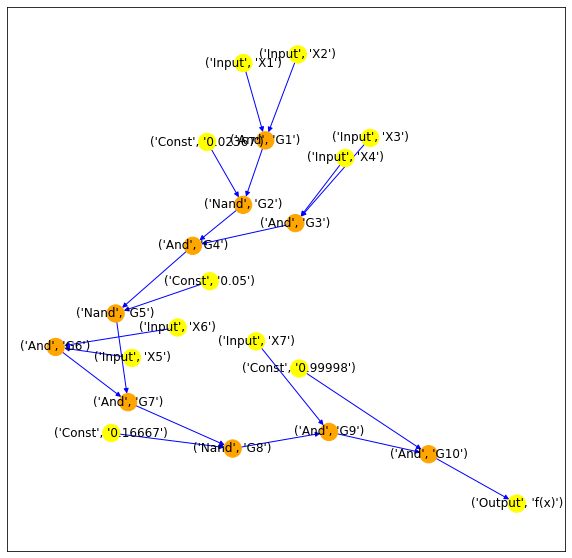

And
[('Input', 'X1'), ('Input', 'X2')]
[('Nand', 'G2')]
X1_0 + X2_0 -> G2_0
X1_0 + X2_1 -> G2_0
X1_1 + X2_0 -> G2_0
X1_1 + X2_1 -> G2_1
----------------------------------------------------------------------------------------------------
Nand
[('And', 'G1'), ('Const', '0.02367')]
[('And', 'G4')]
G1_0 + 0.02367_0 -> G4_1
G1_0 + 0.02367_1 -> G4_1
G1_1 + 0.02367_0 -> G4_1
G1_1 + 0.02367_1 -> G4_0
----------------------------------------------------------------------------------------------------
And
[('Input', 'X3'), ('Input', 'X4')]
[('And', 'G4')]
X3_0 + X4_0 -> G4_0
X3_0 + X4_1 -> G4_0
X3_1 + X4_0 -> G4_0
X3_1 + X4_1 -> G4_1
----------------------------------------------------------------------------------------------------
And
[('And', 'G3'), ('Nand', 'G2')]
[('Nand', 'G5')]
G3_0 + G2_0 -> G5_0
G3_0 + G2_1 -> G5_0
G3_1 + G2_0 -> G5_0
G3_1 + G2_1 -> G5_1
----------------------------------------------------------------------------------------------------
Nand
[('And', 'G4'), ('Const', '0

In [126]:
#    Function(lambda function, point, order, function type)
f2 = Function(lambda x: sin(x), 0, 8, FuncTypes.SINE)
f2.generateCoeffs()
f2.generateCircuit()
f2.generateReactions()

## f3 = log(1+x)

----------------------------------------------------------------------------------------------------
Taylor Coeffs

0 :  0.0
1 :  1.0000003333334788
2 :  -0.5000002500555766
3 :  0.3333343518381025
4 :  -0.24998229036556532
----------------------------------------------------------------------------------------------------
Polynomial Coeffs

0 :  0.0
1 :  1.0000003333334788
2 :  -0.5000002500555766
3 :  0.3333343518381025
4 :  -0.24998229036556532
----------------------------------------------------------------------------------------------------
Horner Expansion Coeffs

1 :  1.0000003333334788
2 :  0.5000000833888094
3 :  0.6666683702679176
4 :  0.749944579630303
Nand - G1
[('Input', 'X1'), ('Const', '0.74994')]
And - G2
[('Nand', 'G1'), ('Const', '0.66667')]
Nand - G3
[('And', 'G2'), ('Input', 'X2')]
And - G4
[('Nand', 'G3'), ('Const', '0.5')]
Nand - G5
[('And', 'G4'), ('Input', 'X3')]
And - G6
[('Nand', 'G5'), ('Const', '1.0')]
And - G7
[('And', 'G6'), ('Input', 'X4')]


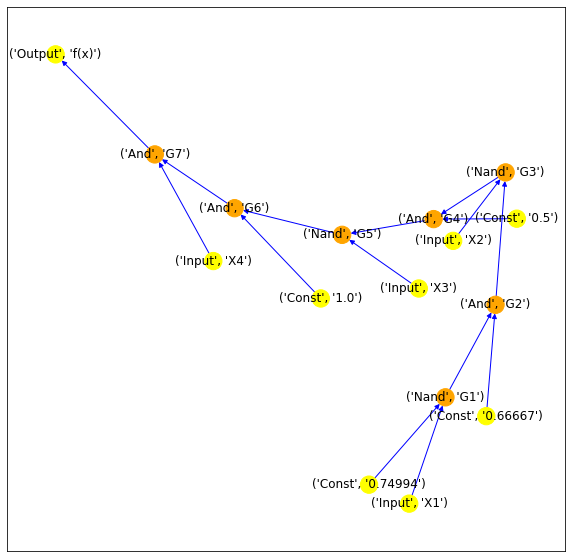

Nand
[('Input', 'X1'), ('Const', '0.74994')]
[('And', 'G2')]
X1_0 + 0.74994_0 -> G2_1
X1_0 + 0.74994_1 -> G2_1
X1_1 + 0.74994_0 -> G2_1
X1_1 + 0.74994_1 -> G2_0
----------------------------------------------------------------------------------------------------
And
[('Nand', 'G1'), ('Const', '0.66667')]
[('Nand', 'G3')]
G1_0 + 0.66667_0 -> G3_0
G1_0 + 0.66667_1 -> G3_0
G1_1 + 0.66667_0 -> G3_0
G1_1 + 0.66667_1 -> G3_1
----------------------------------------------------------------------------------------------------
Nand
[('And', 'G2'), ('Input', 'X2')]
[('And', 'G4')]
G2_0 + X2_0 -> G4_1
G2_0 + X2_1 -> G4_1
G2_1 + X2_0 -> G4_1
G2_1 + X2_1 -> G4_0
----------------------------------------------------------------------------------------------------
And
[('Nand', 'G3'), ('Const', '0.5')]
[('Nand', 'G5')]
G3_0 + 0.5_0 -> G5_0
G3_0 + 0.5_1 -> G5_0
G3_1 + 0.5_0 -> G5_0
G3_1 + 0.5_1 -> G5_1
----------------------------------------------------------------------------------------------------
N

In [127]:
#    Function(lambda function, point, order, function type)
f3 = Function(lambda x: log(x+1), 0, 5, FuncTypes.LOGARITHMIC)
f3.generateCoeffs()
f3.generateCircuit()
f3.generateReactions()

## f4 = cos(x)

----------------------------------------------------------------------------------------------------
Taylor Coeffs

0 :  1.0
1 :  0.0
2 :  -0.4999958333473664
3 :  0.0
4 :  0.041665969748490746
5 :  -1.8503717077085938e-08
6 :  -0.0013883955713506816
7 :  1.982541115402065e-05
----------------------------------------------------------------------------------------------------
Polynomial Coeffs

0 :  1.0
1 :  0.0
2 :  -0.4999958333473664
3 :  0.0
4 :  0.041665969748490746
5 :  -1.8503717077085938e-08
6 :  -0.0013883955713506816
7 :  1.982541115402065e-05
----------------------------------------------------------------------------------------------------
Horner Expansion Coeffs

0 :  1.0
2 :  0.4999958333473664
4 :  0.08333263393325878
6 :  0.033322051058249355
And - G1
[('Input', 'X1'), ('Input', 'X2')]
Nand - G2
[('And', 'G1'), ('Const', '0.03332')]
And - G3
[('Input', 'X3'), ('Input', 'X4')]
And - G4
[('And', 'G3'), ('Nand', 'G2')]
Nand - G5
[('And', 'G4'), ('Const', '0.08333')]
And -

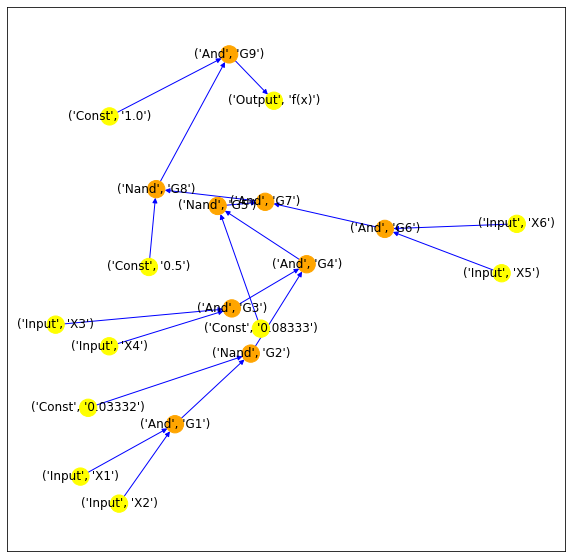

And
[('Input', 'X1'), ('Input', 'X2')]
[('Nand', 'G2')]
X1_0 + X2_0 -> G2_0
X1_0 + X2_1 -> G2_0
X1_1 + X2_0 -> G2_0
X1_1 + X2_1 -> G2_1
----------------------------------------------------------------------------------------------------
Nand
[('And', 'G1'), ('Const', '0.03332')]
[('And', 'G4')]
G1_0 + 0.03332_0 -> G4_1
G1_0 + 0.03332_1 -> G4_1
G1_1 + 0.03332_0 -> G4_1
G1_1 + 0.03332_1 -> G4_0
----------------------------------------------------------------------------------------------------
And
[('Input', 'X3'), ('Input', 'X4')]
[('And', 'G4')]
X3_0 + X4_0 -> G4_0
X3_0 + X4_1 -> G4_0
X3_1 + X4_0 -> G4_0
X3_1 + X4_1 -> G4_1
----------------------------------------------------------------------------------------------------
And
[('And', 'G3'), ('Nand', 'G2')]
[('Nand', 'G5')]
G3_0 + G2_0 -> G5_0
G3_0 + G2_1 -> G5_0
G3_1 + G2_0 -> G5_0
G3_1 + G2_1 -> G5_1
----------------------------------------------------------------------------------------------------
Nand
[('And', 'G4'), ('Const', '0

In [128]:
#    Function(lambda function, point, order, function type)
f4 = Function(lambda x: cos(x), 0, 8, FuncTypes.COSINE)
f4.generateCoeffs()
f4.generateCircuit()
f4.generateReactions()